In [0]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [0]:
#importing data from url

url="https://raw.githubusercontent.com/Concarne2/stock_data/master/DATA/sk%ED%95%98%EC%9D%B4%EB%8B%89%EC%8A%A4(%EC%88%98%EC%A0%95).csv"
csv_df=pd.read_csv(url)

#  0     1    2    3     4      5    6    7
# year,month,day,close,volume,start,high,low


csv_np_raw = csv_df.to_numpy()
row,col = np.shape(csv_np_raw)

for i in range(row):
  for j in range(3,col):
    csv_np_raw[i][j] = csv_np_raw[i][j].replace(",","")

full_data_np = np.flip(csv_np_raw.astype(int),axis=0)
data_np = full_data_np[:,[5,3,6,7,4]]
#data_np = full_data_np[:,[6,3,7,4]]

print(data_np.shape)
#plt.plot(data_np[:,0])

(980, 5)


In [0]:
#normalize data

#data_min = np.min(data_np[:,1])
#data_scale = np.max(data_np[:,1]) - np.min(data_np[:,1])

scaler = MinMaxScaler()
scaler.fit(data_np)
data_norm = scaler.transform(data_np)
data_norm = np.insert(data_norm,0,np.arange(data_norm.shape[0]),axis=1)
#data = torch.from_numpy(data_norm)
#plt.plot(data_norm[:,0])

In [0]:
class MoreBasicLSTM(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
class MoreBasicLSTM_timestamp_processing(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    input_without_timestamp = inputs[:,:,1:]
    batch_size = inputs
    
    _,(hidden,_) = self.lstm(input_without_timestamp)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    print(output.size())
    output = output.view(self.date,1)
    timestamps = torch.from_numpy(np.arange(self.date) + inputs[-1,:,0].item() + 1).view(self.date,1)
    
    return torch.cat([timestamps,output],axis=1)

In [0]:
def train(time_steps, data_target_batches, model, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  #prediction_list=[]
  batch_amount = len(data_target_batches)
  batch_size = list(data_target_batches[0][0].size())[1]
  date = model.date
  model.train()
  
  for data, target in data_target_batches:
    
    assert target[0,0,0].item() == (data[-1,0,0].item() + 1)
    
    optimizer.zero_grad()   
    
    data_without_timestamp = data[:,:,1:]
    
    prediction_batch = model(data_without_timestamp)
    #for p in prediction_batch:
    #  prediction_list.append(p.item())
    target_without_timestamp = torch.squeeze(target[:,:,1])
    loss = criterion(target_without_timestamp, prediction_batch)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  
  return epoch_loss / batch_amount

In [0]:
def evaluate(time_steps, data, target, model, criterion):
  epoch_loss = 0
  epoch_acc = 0
  predictions=[]
  
  date = model.date
  
  model.eval()
  num_tries = list(target.size())[1] - (date - 1)
  
  with torch.no_grad():
    for i in range(num_tries):
      input_data = data[i:i+time_steps,:]
      prediction = torch.squeeze(model(input_data[:,:,1:]))
      
      timestamps = torch.from_numpy(np.arange(date) + input_data[-1,0,0].item() + 1).to(device).view(date,1)
      
      prediction_with_time = torch.cat([timestamps,prediction.view(date,1)],axis=1)
      
      predictions.append(prediction_with_time.tolist())
      loss = criterion(torch.squeeze(target)[i:i+date,1],prediction)

      epoch_loss += loss.item()
    
  return epoch_loss/num_tries, np.array(predictions)

In [0]:
lr = 0.03
time_steps = 30
epoch = 50
batch_size = 5
dropout_rate = 0.3

input_size = 5 #open close high low volume
#hidden1 = 100
hidden = 25
#fc = 15

foresee_date = 5
shuffle = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BasicLSTM(input_size, hidden1, hidden2, fc)
#model = BasicLSTM(input_size, hidden, fc)
model = MoreBasicLSTM(input_size, hidden, dropout_rate, foresee_date)
model = model.to(device)
model = model.double()

#optimizer = optim.SGD(model.parameters(), lr = lr)
optimizer = optim.Adam(model.parameters(), lr = lr)
#criterion = nn.L1Loss()
criterion = nn.MSELoss()
criterion = criterion.to(device)

In [0]:
slice_point = 800

data_train_np = data_norm[:slice_point,:]

data_val_np = data_norm[slice_point:,:]
data_train_tensor = torch.from_numpy(np.expand_dims(data_train_np, axis=1)).to(device)
data_val_tensor = torch.from_numpy(np.expand_dims(data_val_np, axis=1)).to(device)

target_train_np = data_train_np[time_steps:,[0,2]]

target_train_tensor = torch.from_numpy(np.expand_dims(target_train_np, axis=0)).to(device)
target_val_np = data_val_np[time_steps:,[0,2]]
target_val_tensor = torch.from_numpy(np.expand_dims(target_val_np, axis=0)).to(device)

train_batches = []

for i in range((slice_point - time_steps - (foresee_date - 1)) // batch_size):
  data_batch = []
  train_batch = []
  for b in range(batch_size):
    data_batch.append(data_train_tensor[i*batch_size + b:i*batch_size + b + time_steps,:,:])
    train_batch.append(target_train_tensor[:,i*batch_size + b:i*batch_size + b + foresee_date])
    
  train_batches.append((torch.cat(data_batch,axis=1),torch.cat(train_batch,axis=0)))
  

In [0]:
if shuffle:
  random.shuffle(train_batches)
for ep in range(300):
  start_time = time.time()
  
  train_loss = train(time_steps, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%100 == 0:
    print(train_loss)



0.03019562732557113
0.008743513733332235
0.005123575526818237


In [0]:
print(train_loss)

0.008579231277526665


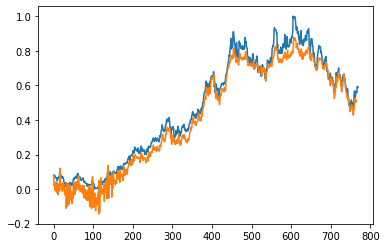

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 1
plt.plot(target_train_np[d - 1:,1])
plt.plot(predictions_train[:,d - 1,1])

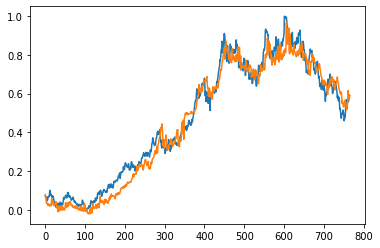

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 5
plt.plot(target_train_np[d - 1:,1])
plt.plot(predictions_train[:,d - 1,1])

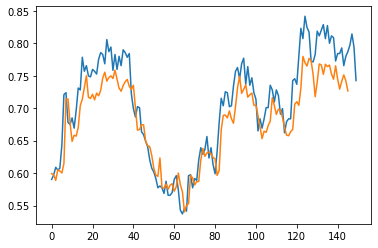

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 1

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

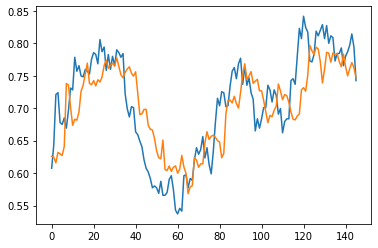

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 5

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

In [0]:
dat = data_norm[691:721,1:]

dat_ten = torch.from_numpy(dat).to(device).view(30,1,5)

predasdf = model(dat_ten)


[[7.21000000e+02 7.04734133e-01]
 [7.22000000e+02 7.09404055e-01]
 [7.23000000e+02 7.12885831e-01]
 [7.24000000e+02 7.15975481e-01]
 [7.25000000e+02 7.17447748e-01]
 [7.26000000e+02 7.16712871e-01]
 [7.27000000e+02 7.15602161e-01]
 [7.28000000e+02 7.15014923e-01]
 [7.29000000e+02 7.14585181e-01]
 [7.30000000e+02 7.14447036e-01]]
[6.90000000e+02 7.39755572e-01 7.09561467e-01 7.18684395e-01
 7.09934735e-01 3.60510061e-01]
tensor([0.7047, 0.7094, 0.7129, 0.7160, 0.7174, 0.7167, 0.7156, 0.7150, 0.7146,
        0.7144], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward1>)


In [0]:

optimizer = optim.Adam(model.parameters(), lr = lr/3)

for ep in range(200):
  start_time = time.time()
  if shuffle:
    random.shuffle(train_batches)
  train_loss = train(time_steps, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)



0.009033489203312178
0.004412237606434502
0.004145705081070478
0.004095084661221717


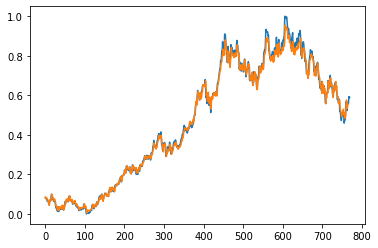

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 1
plt.plot(target_train_np[d - 1:,1])
plt.plot(predictions_train[:,d - 1,1])

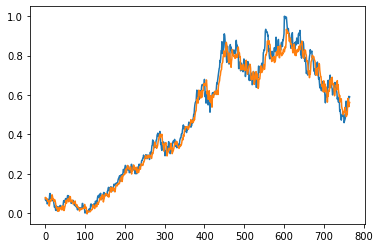

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 5
plt.plot(target_train_np[d - 1:,1])
plt.plot(predictions_train[:,d - 1,1])

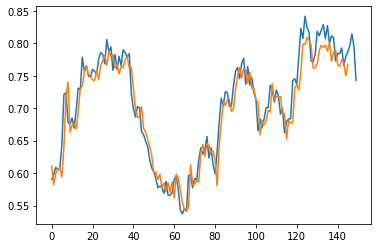

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 1

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

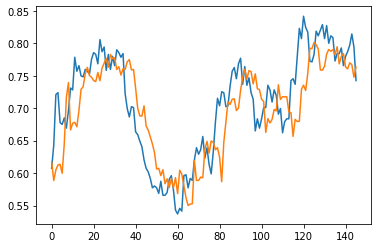

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 5

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

(565, 6, 2)
(570, 2)
30.0
30.0


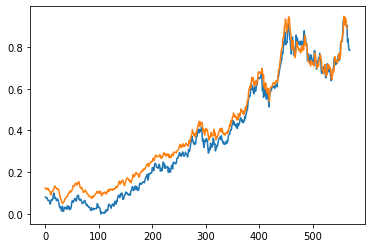

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

print(predictions_train.shape)
print(target_train_np.shape)

plt.plot(target_train_np[:,1])
plt.plot(predictions_train[:,0,1])

print(target_train_np[0,0])
print(predictions_train[0,0,0])


In [0]:
optimizer = optim.Adam(model.parameters(), lr = lr/5)

for ep in range(200):
  start_time = time.time()
  train_loss = train(time_steps, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)

0.0022369577462647413
0.0021760565835223654
0.0020080516904651857
0.00237740953531765


(565, 6, 2)
(570, 2)
34.0
34.0


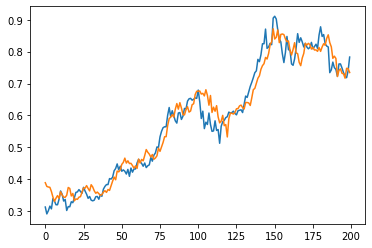

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 5

print(predictions_train.shape)
print(target_train_np.shape)

plt.plot(target_train_np[d - 1:,1][300:500])
plt.plot(predictions_train[:,d - 1,1][300:500])

print(target_train_np[d - 1,0])
print(predictions_train[0,d-1,0])


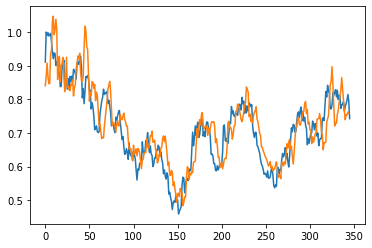

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 5

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

